In [1]:
import sys

DATA_PATH = '../../IFT6758_Data/'
PROJECT_PATH = '../../Milestone2/'


sys.path.append(PROJECT_PATH)

In [2]:
from comet_ml import Experiment
import numpy as np
import pandas as pd
import seaborn as sns
import optuna
import shap
import pickle
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif, SelectFromModel
import os
import xgboost as xgb

from visualizations.simple_visualization import *
from models.generate_plots import *
from features.feature_eng1 import *

In [3]:
X = pd.read_csv(DATA_PATH + '/clean_train_data.csv', index_col=0)

In [4]:
has_nan = X.isna().any().any()
# print(X[X.isna().any(axis=1)].index)
# data.iloc[X[X.isna().any(axis=1)].index]

if has_nan:
    print("There are NaN values in the DataFrame 'X'.")
    # Dropping NaNs since these events do not have x and y coordinates
    X.dropna(inplace=True)
    X = X.reset_index(drop=True)
else:
    print("There are no NaN values in the DataFrame 'X'.")
X.shape
X.dtypes
X = X[~X.isin([np.nan, np.inf, -np.inf]).any(1)]
X = X.reset_index(drop=True)

There are NaN values in the DataFrame 'X'.


In [5]:
X, y = X.iloc[:, :-1], X.iloc[:, -1]

In [6]:
num_cols = X.select_dtypes([np.number]).columns
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

categorical_cols = X.select_dtypes(exclude=["number", "bool_"]).columns
X = pd.get_dummies(data=X, columns=categorical_cols)

boolean_cols = X.select_dtypes([bool]).columns
X[boolean_cols] = X[boolean_cols].astype(int)
X = X.reset_index(drop=True)

In [7]:
# Use best params from previous question
params = {'objective':'binary:logistic',
 'booster': 'gbtree',
 'lambda': 0.04546869697224418,
 'alpha': 0.21038300757945416,
 'max_depth': 6,
 'eta': 0.28859193916460457,
 'gamma': 8.4213865886515e-05,
 'grow_policy': 'depthwise'}

xgb_model = xgb.XGBClassifier(**params)

In [8]:
# Reference: https://scikit-learn.org/stable/modules/feature_selection.html

# Remove features with low variance
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
var_threshold_fold_score = []

for train_idx, val_idx in cv.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
    X_train_var_threshold = sel.fit_transform(X_train)
    xgb_model.fit(X_train_var_threshold, y_train)
    
    X_val_var_threshold = sel.transform(X_val)
    y_pred = xgb_model.predict(X_val_var_threshold)
    accuracy = metrics.accuracy_score(y_val, y_pred)
    
    var_threshold_fold_score.append(accuracy)

var_threshold_score = np.mean(var_threshold_fold_score)
var_threshold_score

0.9079101010735137

In [9]:
# Select K best features
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
k_best_fold_score = []

for train_idx, val_idx in cv.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    sel = SelectKBest(score_func=mutual_info_classif, k=12)
    X_train_var_threshold = sel.fit_transform(X_train, y_train)
    
    xgb_model.fit(X_train_var_threshold, y_train)
    
    X_val_var_threshold = sel.transform(X_val)
    y_pred = xgb_model.predict(X_val_var_threshold)
    accuracy = metrics.accuracy_score(y_val, y_pred)
    
    k_best_fold_score.append(accuracy)

k_best_score = np.mean(k_best_fold_score)
k_best_score

0.907935212505493

In [10]:
# Tree based feature selection
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
tree_fold_score = []

for train_idx, val_idx in cv.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    clf = ExtraTreesClassifier(n_estimators=50)
    clf = clf.fit(X_train, y_train)
    sel = SelectFromModel(clf, prefit=True)
    X_train_var_threshold = sel.transform(X_train)
    
    xgb_model.fit(X_train_var_threshold, y_train)
    
    X_val_var_threshold = sel.transform(X_val)
    y_pred = xgb_model.predict(X_val_var_threshold)
    accuracy = metrics.accuracy_score(y_val, y_pred)
    
    tree_fold_score.append(accuracy)
    
tree_selection_score = np.mean(tree_fold_score)
tree_selection_score

X has feature names, but SelectFromModel was fitted without feature names
X has feature names, but SelectFromModel was fitted without feature names
X has feature names, but SelectFromModel was fitted without feature names
X has feature names, but SelectFromModel was fitted without feature names
X has feature names, but SelectFromModel was fitted without feature names
X has feature names, but SelectFromModel was fitted without feature names
X has feature names, but SelectFromModel was fitted without feature names
X has feature names, but SelectFromModel was fitted without feature names
X has feature names, but SelectFromModel was fitted without feature names
X has feature names, but SelectFromModel was fitted without feature names
X has feature names, but SelectFromModel was fitted without feature names
X has feature names, but SelectFromModel was fitted without feature names
X has feature names, but SelectFromModel was fitted without feature names
X has feature names, but SelectFromMod

0.9078881285705316

In [11]:
# Reference: https://github.com/shap/shap

xgb_fit_model = xgb_model.fit(X, y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(xgb_fit_model)
shap_values = explainer(X)

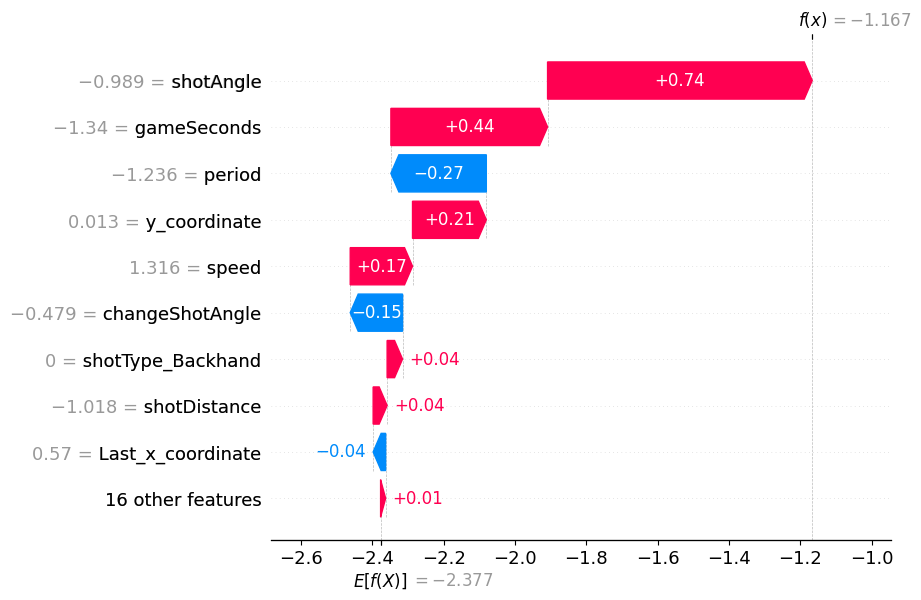

In [13]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

plt.close()

In [15]:
shap.initjs()
shap.plots.force(shap_values[0])

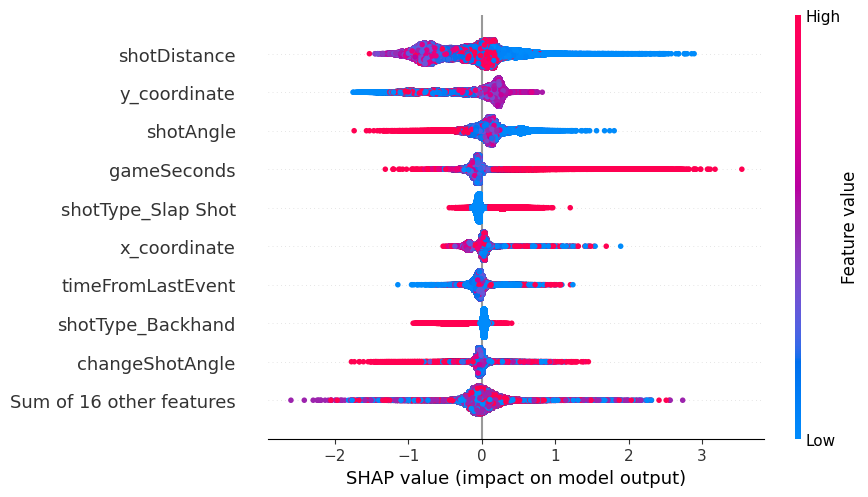

In [17]:
shap.plots.beeswarm(shap_values)

In [18]:
# Reference: https://medium.com/nerd-for-tech/removing-constant-variables-feature-selection-463e2d6a30d9

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

sel = SelectKBest(score_func=mutual_info_classif, k=12)
sel.fit(X_train, y_train)

concol = [column for column in X_train.columns if column not in X_train.columns[sel.get_support()]]

for features in concol:
    print(features)

gameSeconds
Last_x_coordinate
Last_y_coordinate
timeFromLastEvent
changeShotAngle
speed
shotType_Backhand
shotType_Deflected
shotType_Slap Shot
shotType_Snap Shot
shotType_Tip-In
shotType_Wrap-around
LastEventType_Goal


In [19]:
X_train = X_train.drop(concol,axis=1)
X_val = X_val.drop(concol,axis=1)

In [20]:
params = {'objective':'binary:logistic',
 'booster': 'gbtree',
 'lambda': 0.04546869697224418,
 'alpha': 0.21038300757945416,
 'max_depth': 6,
 'eta': 0.28859193916460457,
 'gamma': 8.4213865886515e-05,
 'grow_policy': 'depthwise'}

xgb_model = xgb.XGBClassifier(**params)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_val)
accuracy = metrics.accuracy_score(y_val, y_pred)
print(f'Accuracy score is {accuracy}')

Accuracy score is 0.9076213196057505


In [21]:
pickle.dump(xgb_model, open("feat_select_xgb_model.pkl", "wb"))

In [22]:
experiment = Experiment(
  api_key=os.environ['COMET_API_KEY'],
  project_name="nhl-project-b10",
  workspace="ift6758b-project-b10"
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758b-project-b10/nhl-project-b10/e3fa22323dd34afa999e4cc7398291c5



In [23]:
f1 = metrics.f1_score(y_val, y_pred)
accuracy = metrics.accuracy_score(y_val, y_pred)
precision = metrics.precision_score(y_val, y_pred)
recall = metrics.recall_score(y_val, y_pred)
evaluation = {"accuracy": accuracy, "f1": f1, "recall": recall, "precision": precision, 
              "variance_threshold_score": var_threshold_score ,"k_best_score": k_best_score, 
              "tree_based_selection_score": tree_selection_score }
params = {
    "model": 'XGBoost with Feature Selection',
    "description": 'XGBoost Classifier with Variance Thresholding Feature Selection',
    **xgb_model.get_params()
}

In [24]:
experiment.set_name('XGBoost with Feature Selection')
experiment.log_parameters(params)
experiment.log_metrics(evaluation)

experiment.log_model('5-3 Feature Selection XGBoost Classifier', 'feat_select_xgb_model.pkl')

{'web': 'https://www.comet.com/api/asset/download?assetId=cb311dcb8ec0433bbd9ed3a85d74bf42&experimentKey=e3fa22323dd34afa999e4cc7398291c5',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=cb311dcb8ec0433bbd9ed3a85d74bf42&experimentKey=e3fa22323dd34afa999e4cc7398291c5',
 'assetId': 'cb311dcb8ec0433bbd9ed3a85d74bf42'}

In [25]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758b-project-b10/nhl-project-b10/e3fa22323dd34afa999e4cc7398291c5
COMET INFO:   Metrics:
COMET INFO:     accuracy                   : 0.9076213196057505
COMET INFO:     f1                         : 0.010977932116052424
COMET INFO:     k_best_score               : 0.907935212505493
COMET INFO:     precision                  : 0.30625
COMET INFO:     recall                     : 0.005589141097296681
COMET INFO:     tree_based_selection_score : 0.9078881285705316
COMET INFO:     variance_threshold_score   : 0.9079101010735137
COMET INFO:   Others:
COMET INFO:     Name : XGBoost with Feature Selection
COMET INFO:   Parameters:
C

In [26]:
y_pred_prob = xgb_model.predict_proba(X_val)[:, 1]
df_percentile =  calc_percentile(y_pred_prob, y_val)

goal_rate_df = goal_rate(df_percentile)

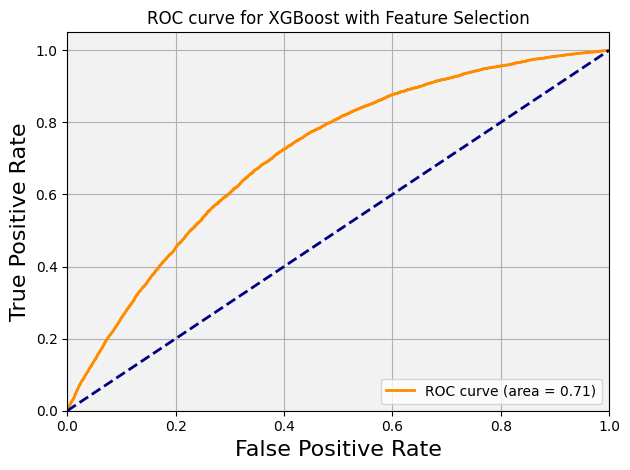

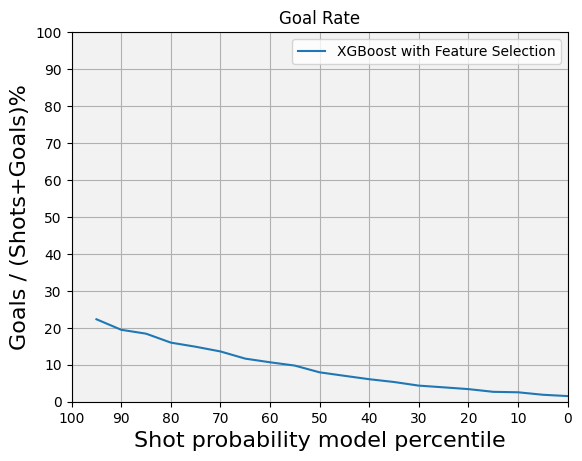

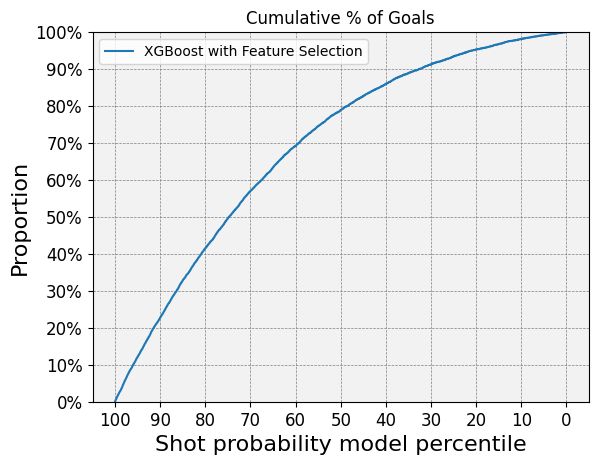

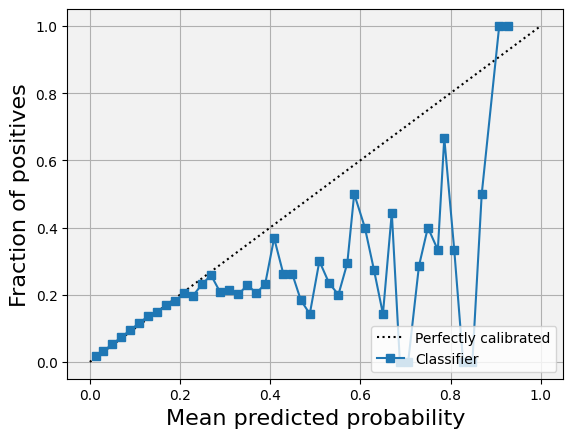

In [27]:
plot_ROC(y_val, y_pred_prob, 'ROC curve for XGBoost with Feature Selection', '5-3a ROC Curve')
plot_goal_rates(goal_rate_df, 'XGBoost with Feature Selection', '5-3b Goal Rate')
plot_cumulative_goal_rates(df_percentile, 'XGBoost with Feature Selection', '5-3c Cumulative Goal Percentage')
plot_calibration_curve_prediction(y_val, y_pred_prob, '5-3d Calibration Plot')